Experiment 02 carried on training model for sentiment analysis with different hyper-parameters
Code for training DistilBERT for sentiment analysis with 10 epochs, learning rate 2e-5 and batch size of 16

In [1]:
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import json
import random
from sklearn.model_selection import train_test_split

# Load your labeled dataset
dataset_path = "/content/combined_dataset.json"
with open(dataset_path, "r") as file:
    data = json.load(file)

# Extract sentences, sentiments, and trends
sentences = [item["sentence"] for item in data]
sentiments = [item["sentiment"] for item in data]
keywords = [item["keywords"] for item in data]
trends = [item["trends"] for item in data]

# Flatten sentences (assuming each "sentence" entry is a list)
flat_sentences = [" ".join(sentence_group) for sentence_group in sentences]

# Split into train and test
train_texts, test_texts, train_sentiments, test_sentiments, train_trends, test_trends = train_test_split(
    flat_sentences, sentiments, trends, test_size=0.2, random_state=42
)


Map:   0%|          | 0/4564 [00:00<?, ? examples/s]

Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-d9dd777c651b>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.298200,0.324757
2,0.234300,0.304258
3,0.174100,0.468573
4,0.013200,0.582454
5,0.000500,0.728738
6,0.030000,0.759929
7,0.018400,0.784926
8,0.014800,0.812813
9,0.022800,0.834042
10,0.000300,0.837535


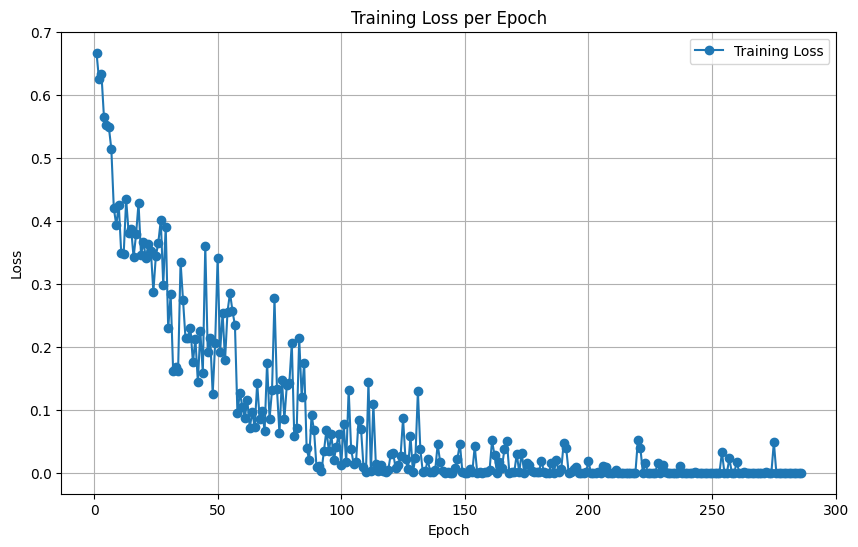

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import torch

# Tokenization
sentiment_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Prepare datasets
train_dataset = Dataset.from_dict({
    "text": train_texts,
    "labels": [1 if sentiment == "positive" else 0 for sentiment in train_sentiments]
})
test_dataset = Dataset.from_dict({
    "text": test_texts,
    "labels": [1 if sentiment == "positive" else 0 for sentiment in test_sentiments]
})

def tokenize_function(examples):
    return sentiment_tokenizer(examples["text"], truncation=True, padding=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Model setup
sentiment_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
)

# Custom callback to track training loss
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append(logs["loss"])

# Initialize loss tracker
loss_tracker = LossTrackerCallback()

# Trainer
trainer = Trainer(
    model=sentiment_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=sentiment_tokenizer,
    callbacks=[loss_tracker],
)

# Fine-tune the model
trainer.train()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_tracker.losses) + 1), loss_tracker.losses, marker='o', label="Training Loss")
plt.title("Training Loss per Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Calculate metrics
accuracy = accuracy_score(test_dataset["labels"], preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_dataset["labels"], preds, average="binary")

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Accuracy: 0.8738, Precision: 0.8881, Recall: 0.9084, F1 Score: 0.8982
